In [ ]:
import requests
from bs4 import BeautifulSoup
import json, csv, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

In [ ]:
def get_all_url_for_year(year = 2020):
  all_url = []
  month_url = ['https://www.thehindu.com/archive/web/{}/0{}/'.format(year, x+1) for x in range(8)]
  month_url.extend(['https://www.thehindu.com/archive/web/{}/{}/'.format(year, x+1) for x in range(8, 12, 1)])
  # print(month_url)
  for murl in month_url:
    page_request = requests.get(murl)
    data = page_request.content
    soup = BeautifulSoup(data,"html.parser")
    all_url.extend([x['href'] for x in soup.find_all('a', class_ = 'ui-state-default')])
  return all_url
url_tt = get_all_url_for_year(year = 2020)

In [ ]:
def get_news_content(url):
  data_sp = requests.get(url).content
  sp_content = BeautifulSoup(data_sp,"html.parser")
  for x in sp_content.find_all('div'):
    if 'id' in x.attrs:
      if 'content-body' in x['id']:
        # print(url_temp)
        content_temp = '\n'.join(y.text for y in x.find_all('p'))
        return content_temp

In [ ]:
def generate_data(urls, topic_list, file_name = 'the_hindu_news_labels_100_300_sc_tech_soc.csv'):
  data_dir = '/content/drive/MyDrive/news_analysis/assets/raw_data'
  file_name = os.path.join(data_dir, file_name)
  csv_file = open(file_name, 'w')
  csv_writer = csv.writer(csv_file)
  csv_writer.writerow(['headline', 'links', 'content', 'labels'])
  data_dict = defaultdict(lambda: defaultdict(list))
  for url in urls:
    page_request = requests.get(url)
    data = page_request.content
    soup = BeautifulSoup(data,"html.parser")
    sections = [x for x in soup.find_all('section') if list(x.attrs.keys()) == ['id']]
    for section in sections:
      if section:
        labels_text = section.find('a', {'class':'section-list-heading'}).text
        topic = labels_text.replace('\n', '')
        if topic in topic_list:
          heading_list = [x.text.replace('\n', '') for x in section.find_all('li')[1:]]
          url_list = [x.a['href'] for x in section.find_all('li')[1:]]
          content_list = [get_news_content(url) for url in url_list]
          data_dict[topic]['headings']+= heading_list
          data_dict[topic]['urls']+= url_list
          data_dict[topic]['content']+= content_list
          for head, link, con in zip(heading_list, url_list, content_list):
            csv_writer.writerow([head, link, con, topic]) 
          # print('Label:{0}\nHeadings:{1}\nURLs:{2}\nContent:{3}\n\n\n'.format(topics,heading_list,url_list, content_list))
  return data_dict
# topic_list = ['races', 'economy', 'technology', 'international', 'business', 'cricket','society', 'science', 'travel','markets', 'movies', 'entertainment','national', 'other sports']
topic_list = ['economy', 'business', 'markets', 'technology', 'society', 'science', 'movies', 'entertainment', 'other sports']
data_dict = generate_data(url_tt[60:100], topic_list, file_name = 'the_hindu_news_labels_60_100_days.csv')

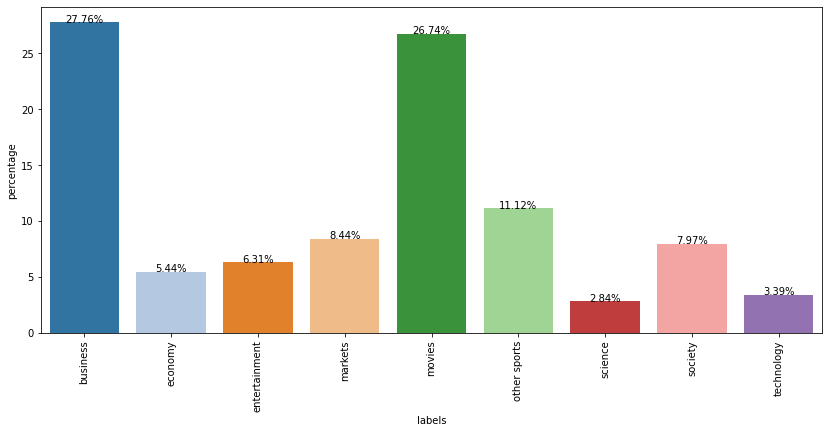

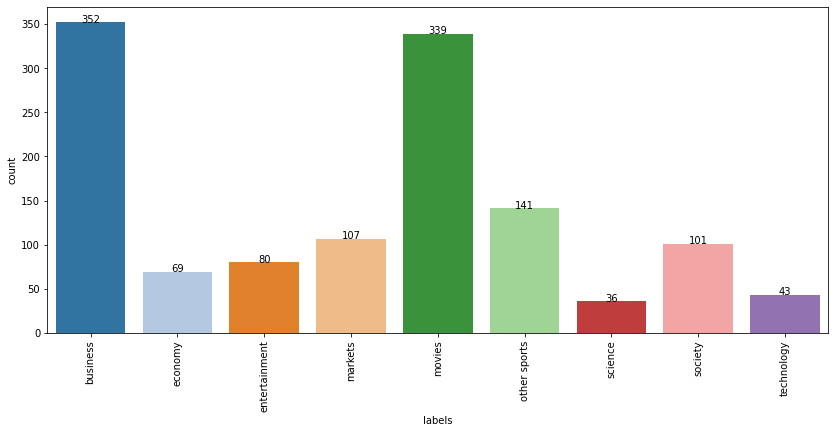

In [ ]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, str(int(float(value))), ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def show_values_on_bars_percentage(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def plot_labels_count(df, label_col_name = 'labels', 
                      text_col_name = 'content', 
                      file_name = 'raw_data_labels_count_60_100.jpg'):
  df_temp = pd.DataFrame(df.groupby([label_col_name]).count()[text_col_name]).reset_index()
  df_temp = df_temp.rename(columns={"content": "count"})
  df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
  fig = plt.figure(figsize = (14, 6))
  ax = sns.barplot(x = 'labels', y = 'count',data = df_temp, palette='tab20')
  show_values_on_bars(ax)
  plt.xticks(rotation = 90)

  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
  plt.show()

def plot_labels_percentage(df, label_col_name = 'labels', 
                      text_col_name = 'content', 
                      file_name = 'raw_data_labels_percentage_60_100.jpg'):
  df_temp = pd.DataFrame(df.groupby([label_col_name]).count()[text_col_name]).reset_index()
  df_temp = df_temp.rename(columns={"content": "count"})
  df_temp['percentage'] = (df_temp['count']/df_temp['count'].sum()) * 100
  fig = plt.figure(figsize = (14, 6))
  ax = sns.barplot(x = 'labels', y = 'percentage',data = df_temp, palette='tab20')
  show_values_on_bars_percentage(ax)
  plt.xticks(rotation = 90)

  dir_path = '/content/drive/MyDrive/news_analysis/assets/figs'
  file_name = os.path.join(dir_path, file_name)
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
  plt.show()


data_dir = data_dir = '/content/drive/MyDrive/news_analysis/assets/raw_data'
raw_data_path = 'the_hindu_news_labels_60_100_days.csv'
raw_data_path = os.path.join(data_dir, raw_data_path)
df = pd.read_csv(raw_data_path)
plot_labels_percentage(df, file_name = 'raw_data_labels_percentage_60_100.jpg')
plot_labels_count(df, file_name = 'raw_data_labels_percentage_60_100.jpg')

In [ ]:
with open('the_hindu_news_2020_60_days.json', 'w') as f:
  json.dump(data_dict, f, indent = 4)